## Low-level benchmarks

The code in this notebook should be run from the base SHEEP directory, and relies on an sqlite file called sheep.db being present in the frontend/ subdirectory.
Dependencies are:
* pandas
* numpy
* matplotlib
* sqlalchemy

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Import some SQLAlchemy utilities from the SHEEP frontend code.

In [2]:
from frontend.database import BenchmarkMeasurement, session
from frontend.database import build_filter

How long do nested ADDITIONS take in each library on boolean inputs? (In the below, the "depth" value represents the number of the selected operations performed).

In [3]:
all_rows = pd.read_sql(session.query(BenchmarkMeasurement).statement,session.bind)
all_rows.head()
print(set(all_rows.is_correct))
false_rows = all_rows[(all_rows.is_correct==False) & (all_rows.context_name=="SEAL")]
print(set(false_rows.context_name))
false_rows.head(100)
#assert set(all_rows.is_correct) == set([True])

{False, True}
{'SEAL'}


,id,context_name,input_bitwidth,input_signed,gate_name,depth,num_slots,tbb_enabled,parameters,execution_time,is_correct,ciphertext_size,private_key_size,public_key_size
530,531,SEAL,1,False,ADD,3,1,False,Default,0.00020,False,96,96,120
531,532,SEAL,1,False,ADD,4,1,False,Default,0.00019,False,96,96,120
532,533,SEAL,1,False,ADD,5,1,False,Default,0.00027,False,96,96,120
565,566,SEAL,1,False,MULTIPLY,3,1,False,Default,0.00680,False,96,96,120
566,567,SEAL,1,False,MULTIPLY,4,1,False,Default,0.01090,False,96,96,120
567,568,SEAL,1,False,MULTIPLY,5,1,False,Default,0.01486,False,96,96,120
570,571,SEAL,8,True,MULTIPLY,3,1,False,Default,0.00673,False,96,96,120
571,572,SEAL,8,True,MULTIPLY,4,1,False,Default,0.01093,False,96,96,120
572,573,SEAL,8,True,MULTIPLY,5,1,False,Default,0.01357,False,96,96,120
575,576,SEAL,8,False,MULTIPLY,3,1,False,Default,0.00687,False,96,96,120


In [4]:
def libs_op_depth(op_str, bitwidth, is_signed, libs_list):
    rows = all_rows[(all_rows.input_bitwidth==bitwidth) & (all_rows.gate_name==op_str) & all_rows.context_name.isin(libs_list) & (all_rows.input_signed==is_signed)]
    rows.context_name.name = "Library"
    rows.execution_time.name = "Time (s)" 
    return rows.pivot(index='context_name', columns='depth', values='execution_time')


{'SELECT', 'NEGATE', 'ADD', 'MULTIPLY', 'SUBTRACT', 'COMPARE'}


/home/adria/.virtualenvs/metisml/lib/python3.6/site-packages/matplotlib/axes/_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


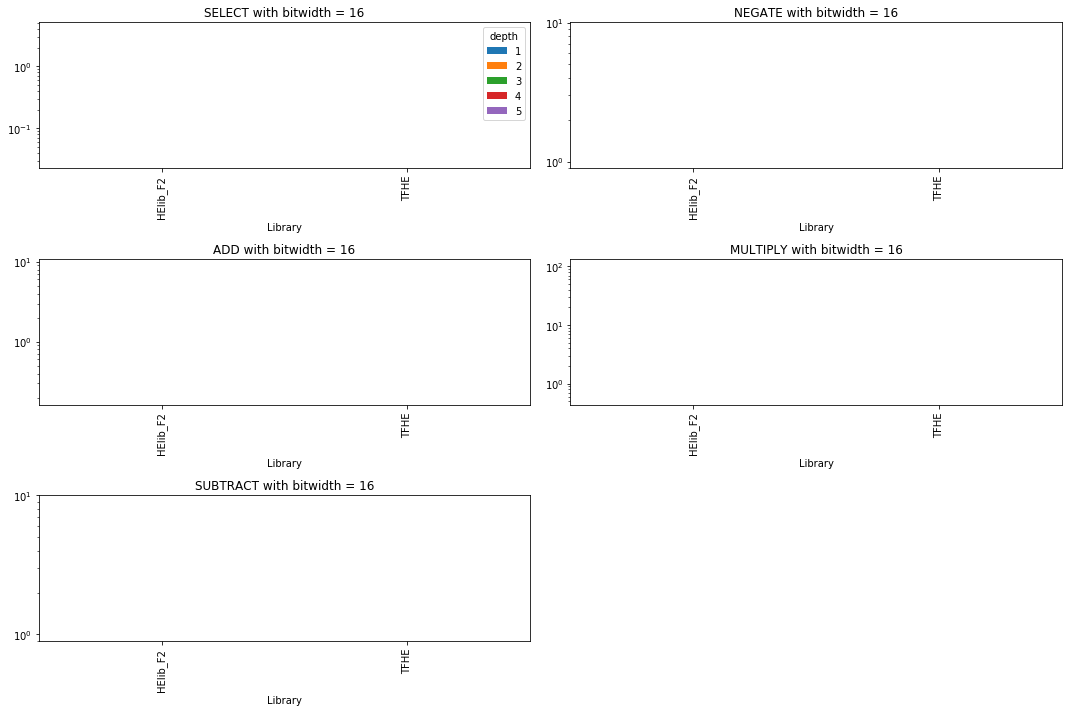

In [8]:
all_ops = set(all_rows.gate_name)
print(all_ops)
all_libs = ["HElib_F2", "HElib_Fp", "TFHE", "SEAL"]
bitwidth = 16
is_signed = True
for i, op in enumerate(all_ops):
    if op == "COMPARE": continue 
    libs = ["HElib_Fp", "SEAL"]
    libs = ["HElib_F2", "TFHE"]# all_libs
    rows = libs_op_depth(op, bitwidth, is_signed, libs)
    axis = plt.subplot((len(all_ops) + 2 // 2) // 2, 2, i + 1)
    #axis.set_yscale("log")
    l = rows.plot(ax=axis, title=op + ' with bitwidth = ' + str(bitwidth), kind='bar', figsize=(15, 10), legend=False if i!=0 else True)
plt.tight_layout()
plt.show()

For HElib_F2, how do the different operations scale with input bitwidth? 

In [6]:
helibf2_depth1 = all_rows[(all_rows.context_name=="HElib_F2")&(all_rows.input_signed==0)&(all_rows.depth==1)]

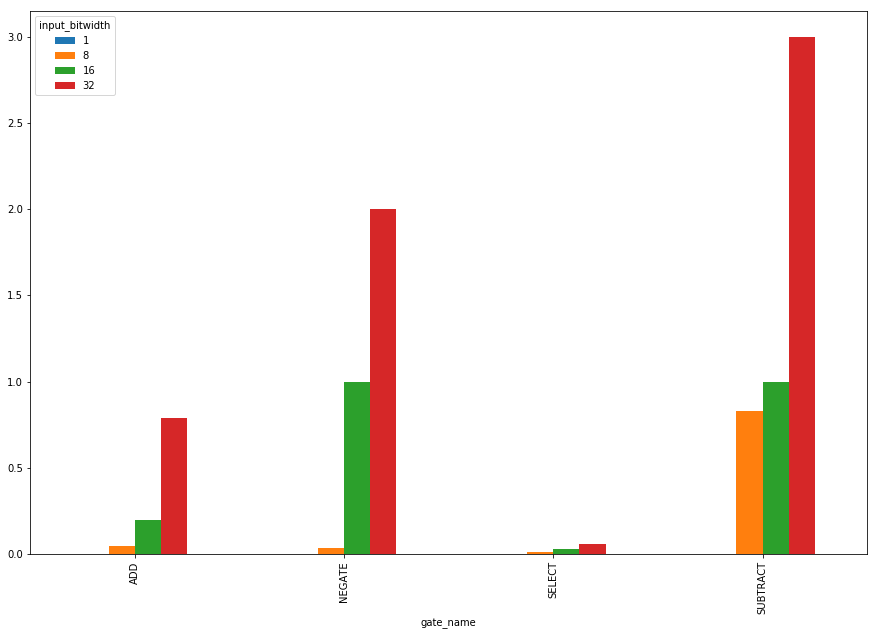

In [69]:
ax = helibf2_depth1.pivot(index='gate_name', columns='input_bitwidth', values='execution_time').plot(kind='bar',figsize=(15,10),legend=True)
plt.show()

Same for HElib_Fp

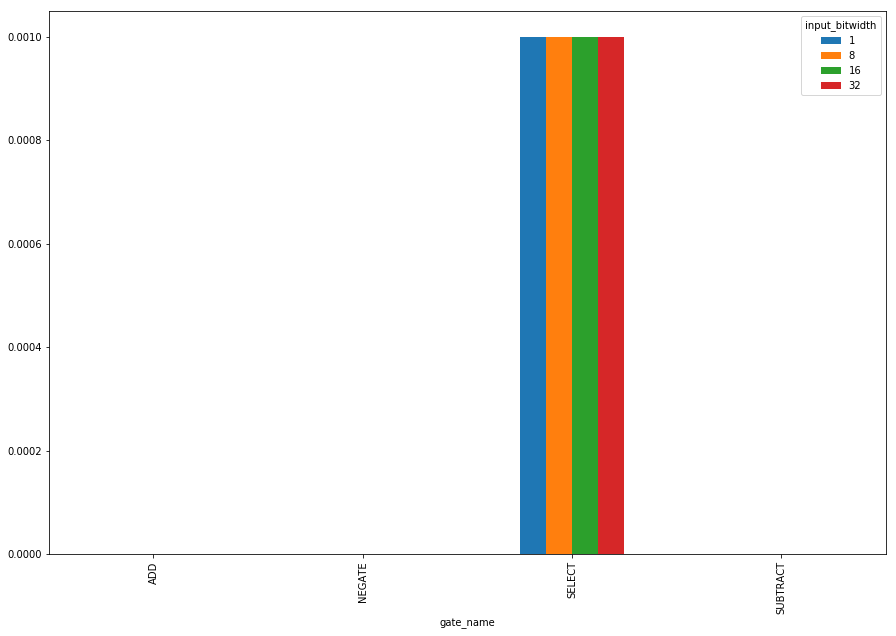

In [70]:
helibfp_depth1 = all_rows[(all_rows.context_name=="HElib_Fp")&(all_rows.input_signed==0)&(all_rows.depth==1)]
ax = helibfp_depth1.pivot(index='gate_name', columns='input_bitwidth', values='execution_time').plot(kind='bar',figsize=(15,10),legend=True)
plt.show()

And for TFHE

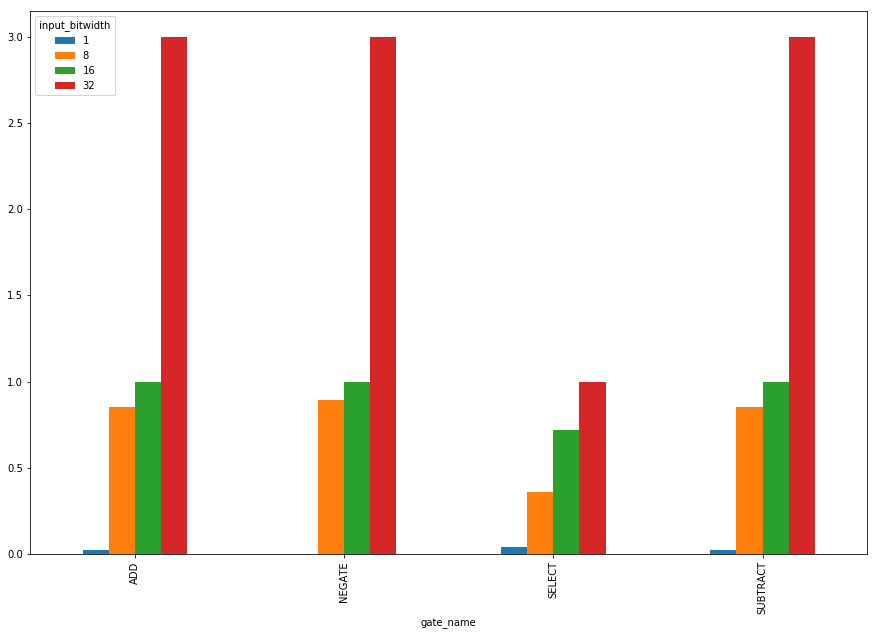

In [72]:
tfhe_depth1 = all_rows[(all_rows.context_name=="TFHE")&(all_rows.input_signed==0)&(all_rows.depth==1)]
ax = tfhe_depth1.pivot(index='gate_name', columns='input_bitwidth', values='execution_time').plot(kind='bar',figsize=(15,10),legend=True)
plt.show()